## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
from tensorflow import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [9]:
# 載入 Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.1]
redice_lr_patient = [5, 10]

In [11]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

50000/50000 [==============================] - 2s 42us/sample - loss: 1.3447 - accuracy: 0.5317 - val_loss: 1.5035 - val_accuracy: 0.4673
Epoch 11/25
50000/50000 [==============================] - 2s 42us/sample - loss: 1.3203 - accuracy: 0.5415 - val_loss: 1.4882 - val_accuracy: 0.4750
Epoch 12/25
50000/50000 [==============================] - 2s 42us/sample - loss: 1.2958 - accuracy: 0.5509 - val_loss: 1.4808 - val_accuracy: 0.4789
Epoch 13/25
50000/50000 [==============================] - 2s 42us/sample - loss: 1.2737 - accuracy: 0.5573 - val_loss: 1.4696 - val_accuracy: 0.4846
Epoch 14/25
50000/50000 [==============================] - 2s 42us/sample - loss: 1.2496 - accuracy: 0.5670 - val_loss: 1.4636 - val_accuracy: 0.4839
Epoch 15/25
50000/50000 [==============================] - 2s 42us/sample - loss: 1.2287 - accuracy: 0.5749 - val_loss: 1.4518 - val_accuracy: 0.4891
Epoch 16/25
50000/50000 [==============================] - 2s 43us/sample - loss: 1.2094 - accuracy: 0.5819 - va

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 57us/sample - loss: 2.2097 - accuracy: 0.2720 - val_loss: 2.1603 - val_accuracy: 0.2162
Epoch 2/25
50000/50000 [==============================] - 2s 42us/sample - loss: 1.7660 - accuracy: 0.3825 - val_loss: 2.0112 - val_accuracy: 0.3119
Epoch 3/25
50000/50000 [==============================] - 2s 41us/sample - loss: 1.6412 - accuracy: 0.4223 - val_loss: 1.8659 - val_accuracy: 0.3637
Epoch 4/25
50000/50000 [==============================] - 2s 42us/sample - loss: 1.5655 - accuracy: 0.4493 - val_loss: 1.7308 - val_accuracy: 0.4059
Epoch 5/25
50000/50000 [==============================] - 2s 41us/sample - loss: 1.5128 - accuracy: 0.4691 - val_loss: 1.6490 - val_accuracy: 0.4300
Epoch 6/25
50000/50000 [==============================] - 2s 42us/sample - loss: 1.4686 - accuracy: 0.4843 - val_loss: 1.6045 - val_accuracy: 0.4341
Epoch 7/25
50000/50000 [==============================] 

50000/50000 [==============================] - 2s 44us/sample - loss: 0.5251 - accuracy: 0.8323 - val_loss: 1.7197 - val_accuracy: 0.4802
Epoch 20/25
48128/50000 [===========================>..] - ETA: 0s - loss: 0.4944 - accuracy: 0.8418
Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
50000/50000 [==============================] - 2s 44us/sample - loss: 0.4959 - accuracy: 0.8408 - val_loss: 1.7048 - val_accuracy: 0.4885
Epoch 21/25
50000/50000 [==============================] - 2s 45us/sample - loss: 0.4264 - accuracy: 0.8736 - val_loss: 1.6099 - val_accuracy: 0.5075
Epoch 22/25
50000/50000 [==============================] - 2s 44us/sample - loss: 0.3904 - accuracy: 0.8888 - val_loss: 1.5859 - val_accuracy: 0.5180
Epoch 23/25
50000/50000 [==============================] - 2s 45us/sample - loss: 0.3731 - accuracy: 0.8967 - val_loss: 1.6504 - val_accuracy: 0.5085
Epoch 24/25
50000/50000 [==============================] - 2s 44us/sample - loss: 0.3583 - ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 62us/sample - loss: 1.8741 - accuracy: 0.3631 - val_loss: 2.0969 - val_accuracy: 0.2353
Epoch 2/25
50000/50000 [==============================] - 2s 44us/sample - loss: 1.5382 - accuracy: 0.4622 - val_loss: 1.8717 - val_accuracy: 0.3352
Epoch 3/25
50000/50000 [==============================] - 2s 43us/sample - loss: 1.4419 - accuracy: 0.4966 - val_loss: 1.7133 - val_accuracy: 0.4242
Epoch 4/25
50000/50000 [==============================] - 2s 44us/sample - loss: 1.3744 - accuracy: 0.5215 - val_loss: 1.5947 - val_accuracy: 0.4533
Epoch 5/25
50000/50000 [==============================] - 2s 44us/sample - loss: 1.3217 - accuracy: 0.5398 - val_loss: 1.5866 - val_accuracy: 0.4445
Epoch 6/25
50000/50000 [==============================] - 2s 44us/sample - loss: 1.2799 - accuracy: 0.5556 - val_loss: 1.5375 - val_accuracy: 0.4621
Epoch 7/25
50000/50000 [==============================] 

50000/50000 [==============================] - 2s 46us/sample - loss: 2.2039 - accuracy: 0.2661 - val_loss: 2.2412 - val_accuracy: 0.2556
Epoch 19/25
50000/50000 [==============================] - 2s 46us/sample - loss: 2.1914 - accuracy: 0.2685 - val_loss: 2.2328 - val_accuracy: 0.2580
Epoch 20/25
50000/50000 [==============================] - 2s 45us/sample - loss: 2.1798 - accuracy: 0.2726 - val_loss: 2.2236 - val_accuracy: 0.2590
Epoch 21/25
50000/50000 [==============================] - 2s 46us/sample - loss: 2.1692 - accuracy: 0.2755 - val_loss: 2.2146 - val_accuracy: 0.2614
Epoch 22/25
50000/50000 [==============================] - 2s 45us/sample - loss: 2.1584 - accuracy: 0.2778 - val_loss: 2.2056 - val_accuracy: 0.2629
Epoch 23/25
50000/50000 [==============================] - 2s 45us/sample - loss: 2.1487 - accuracy: 0.2794 - val_loss: 2.1965 - val_accuracy: 0.2650
Epoch 24/25
50000/50000 [==============================] - 2s 46us/sample - loss: 2.1400 - accuracy: 0.2824 - va

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 68us/sample - loss: 1.9541 - accuracy: 0.3349 - val_loss: 2.1431 - val_accuracy: 0.1992
Epoch 2/25
50000/50000 [==============================] - 2s 46us/sample - loss: 1.6366 - accuracy: 0.4276 - val_loss: 1.9681 - val_accuracy: 0.2907
Epoch 3/25
50000/50000 [==============================] - 2s 46us/sample - loss: 1.5225 - accuracy: 0.4663 - val_loss: 1.7919 - val_accuracy: 0.3673
Epoch 4/25
50000/50000 [==============================] - 2s 46us/sample - loss: 1.4416 - accuracy: 0.4932 - val_loss: 1.6845 - val_accuracy: 0.4066
Epoch 5/25
50000/50000 [==============================] - 2s 46us/sample - loss: 1.3765 - accuracy: 0.5164 - val_loss: 1.5760 - val_accuracy: 0.4419
Epoch 6/25
50000/50000 [==============================] - 2s 47us/sample - loss: 1.3238 - accuracy: 0.5346 - val_loss: 1.5309 - val_accuracy: 0.4527
Epoch 7/25
50000/50000 [==============================] 

50000/50000 [==============================] - 2s 43us/sample - loss: 1.0977 - accuracy: 0.6278 - val_loss: 1.4812 - val_accuracy: 0.4840
Epoch 20/25
50000/50000 [==============================] - 2s 43us/sample - loss: 1.0801 - accuracy: 0.6343 - val_loss: 1.5182 - val_accuracy: 0.4726
Epoch 21/25
50000/50000 [==============================] - 2s 44us/sample - loss: 1.0619 - accuracy: 0.6412 - val_loss: 1.4703 - val_accuracy: 0.4897
Epoch 22/25
50000/50000 [==============================] - 2s 45us/sample - loss: 1.0444 - accuracy: 0.6475 - val_loss: 1.5072 - val_accuracy: 0.4733
Epoch 23/25
50000/50000 [==============================] - 2s 44us/sample - loss: 1.0254 - accuracy: 0.6549 - val_loss: 1.4877 - val_accuracy: 0.4824
Epoch 24/25
50000/50000 [==============================] - 2s 44us/sample - loss: 1.0102 - accuracy: 0.6598 - val_loss: 1.4929 - val_accuracy: 0.4819
Epoch 25/25
50000/50000 [==============================] - 2s 45us/sample - loss: 0.9940 - accuracy: 0.6679 - va

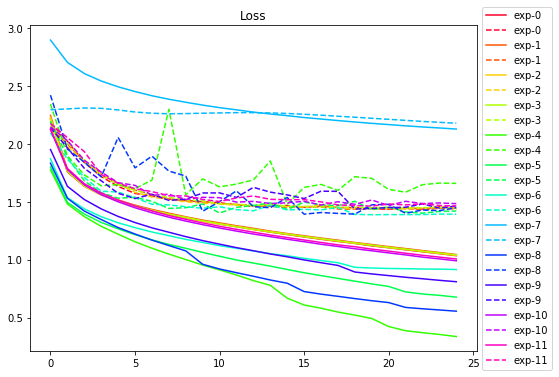

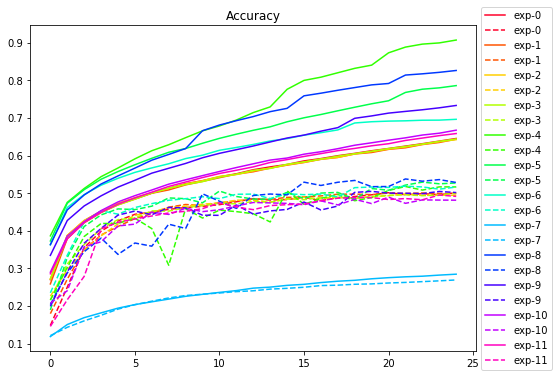

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()